# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression



In [1]:
version  = '07'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    r_s  = xr.open_dataset(fname).rime_rimedsnow.values
    v_s  = xr.open_dataset(fname).rvol_rimedsnow.values
    liq  = xr.open_dataset(fname).liq_rimedsnow.values
    cwc  = xr.open_dataset(fname).cwc.values
    r_c  = xr.open_dataset(fname).rc.values
    # process rates
    mult_num = xr.open_dataset(fname).mult_rimedsnow_num.values
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction (no log transform for this)
    liq = np.where(q_s>q_min,liq/q_s,np.nan)
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    cwc = np.log(cwc, where=cwc>q_min, out=np.nan*n_s)
    r_c = np.log(r_c, where=r_c>q_min, out=np.nan*n_s)
    mult_num = np.log(mult_num, where=mult_num>p_min, out=np.nan*mult_num)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq, cwc, r_c, temp, rho, mult_num ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liqfrac', 'cwc', 'r_c', 'temp', 'rho', 'mult_num' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  97438.000000  97438.000000  97438.000000  97438.000000  97438.000000   
mean      -5.765099      4.448942     -6.412295    -12.536249      0.031124   
std        1.818441      2.905110      2.000331      1.821810      0.083398   
min      -22.951300     -7.918494    -23.163723    -29.147425      0.000000   
25%       -6.383382      2.532843     -7.264980    -13.063317      0.000013   
50%       -5.463971      4.711151     -6.174834    -12.240188      0.001004   
75%       -4.733452      6.573247     -5.070541    -11.512726      0.013048   
max       -3.507425     11.563048     -3.592370     -8.961373      0.989692   

                cwc           r_c          temp           rho      mult_num  
count  97438.000000  97438.000000  97438.000000  97438.000000  97438.000000  
mean     -11.113526    -10.996167    267.741302      1.045600     -3.011664  
std        2.874186      0.491121      1.397822      0.050136      4.210134  
min      -31.273018    -12.203955    264.920013      0.841000    -16.801191  
25%      -12.840951    -11.333467    266.600006      1.011000     -5.215605  
50%      -10.766237    -10.957886    267.799988      1.046000     -1.767534  
75%       -9.061920    -10.565369    268.929993      1.082000      0.062933  
max       -3.897134    -10.260165    270.149994      1.223000      5.923868

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s       liqfrac       cwc  \
0 -8.190158  8.328547 -12.067076 -17.079985  4.633522e-08 -8.772085   
1 -8.145182  8.327775 -10.987842 -16.001913  0.000000e+00 -8.859683   
2 -8.104156  8.323147 -10.500016 -15.516023  5.198491e-06 -8.947976   
4 -8.032917  8.313460  -9.967386 -14.986661  0.000000e+00 -9.142682   
5 -8.001977  8.308913  -9.796159 -14.817060  0.000000e+00 -9.247005   

         r_c        temp    rho  mult_num  
0 -12.155304  265.890015  1.038  0.996148  
1 -12.155304  265.950012  1.039  1.049720  
2 -12.155304  266.019989  1.040  1.098532  
4 -12.155304  266.140015  1.042  1.172132  
5 -12.155304  266.209991  1.043  1.212679

In [11]:
dataset_train.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  68203.000000  68203.000000  68203.000000  68203.000000  68203.000000   
mean      -5.763450      4.449460     -6.409261    -12.534072      0.031239   
std        1.819845      2.903710      2.002918      1.822478      0.083735   
min      -22.905493     -7.918494    -23.011850    -29.100349      0.000000   
25%       -6.382021      2.519791     -7.261100    -13.058192      0.000012   
50%       -5.463357      4.713756     -6.173226    -12.234904      0.000994   
75%       -4.731505      6.577124     -5.065754    -11.512726      0.012953   
max       -3.507425     11.563048     -3.592370     -8.961373      0.989692   

                cwc           r_c          temp           rho      mult_num  
count  68203.000000  68203.000000  68203.000000  68203.000000  68203.000000  
mean     -11.124348    -10.996903    267.735504      1.045339     -3.015523  
std        2.876564      0.490589      1.398612      0.050132      4.209883  
min      -28.879293    -12.203955    264.920013      0.841000    -16.801191  
25%      -12.863853    -11.334051    266.589996      1.011000     -5.212369  
50%      -10.780558    -10.959575    267.790009      1.045000     -1.774336  
75%       -9.070579    -10.566035    268.929993      1.082000      0.063782  
max       -3.897134    -10.260165    270.149994      1.220000      5.923868

In [12]:
dataset_test.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  14694.000000  14694.000000  14694.000000  14694.000000  14694.000000   
mean      -5.769344      4.439752     -6.417284    -12.540363      0.030490   
std        1.823067      2.898823      1.998202      1.819291      0.081753   
min      -22.606615     -7.610246    -22.685244    -28.314356      0.000000   
25%       -6.385723      2.531731     -7.284083    -13.075432      0.000013   
50%       -5.463687      4.700435     -6.184176    -12.252598      0.001025   
75%       -4.730036      6.565170     -5.073280    -11.514206      0.013426   
max       -3.510432     11.365330     -3.603326     -9.072494      0.816696   

                cwc           r_c          temp           rho      mult_num  
count  14694.000000  14694.000000  14694.000000  14694.000000  14694.000000  
mean     -11.108568    -10.991805    267.749908      1.046168     -3.022397  
std        2.869599      0.492199      1.400288      0.050346      4.213837  
min      -31.273018    -12.203955    264.989990      0.855000    -16.801191  
25%      -12.807552    -11.331679    266.579987      1.012000     -5.224790  
50%      -10.756804    -10.948339    267.799988      1.047000     -1.764223  
75%       -9.061920    -10.559593    268.940002      1.082000      0.033611  
max       -4.154095    -10.260165    270.149994      1.223000      5.116376

In [13]:
dataset_val.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  14541.000000  14541.000000  14541.000000  14541.000000  14541.000000   
mean      -5.768538      4.455797     -6.421482    -12.542297      0.031219   
std        1.807248      2.918169      1.990410      1.821325      0.083466   
min      -22.951300     -7.899497    -23.163723    -29.147425      0.000000   
25%       -6.386168      2.595180     -7.260253    -13.068065      0.000015   
50%       -5.467991      4.709890     -6.173562    -12.251865      0.001030   
75%       -4.743203      6.550266     -5.089386    -11.511526      0.013071   
max       -3.511436     11.545587     -3.602592     -9.075198      0.784006   

                cwc           r_c          temp           rho      mult_num  
count  14541.000000  14541.000000  14541.000000  14541.000000  14541.000000  
mean     -11.067775    -10.997118    267.759857      1.046250     -2.982718  
std        2.867380      0.492535      1.391497      0.049934      4.207733  
min      -26.515879    -12.203955    264.970001      0.844000    -16.801191  
25%      -12.761199    -11.334763    266.640015      1.012000     -5.217670  
50%      -10.710924    -10.962287    267.829987      1.046000     -1.744599  
75%       -9.011490    -10.565144    268.950012      1.082000      0.084580  
max       -3.995404    -10.260165    270.149994      1.222000      4.963313

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  68062.000000  68062.000000  68062.000000  68062.000000  68062.000000   
mean      -5.731374      4.467721     -6.378319    -12.504087      0.031301   
std        1.679205      2.878241      1.885624      1.700655      0.083810   
min      -19.996828     -7.574514    -20.246225    -26.684860      0.000000   
25%       -6.376583      2.534907     -7.252491    -13.051719      0.000013   
50%       -5.459320      4.717472     -6.169300    -12.231637      0.001005   
75%       -4.729269      6.582700     -5.063708    -11.511327      0.013023   
max       -3.507425     11.563048     -3.592370     -8.961373      0.989692   

                cwc           r_c          temp           rho      mult_num  
count  68062.000000  68062.000000  68062.000000  68062.000000  68062.000000  
mean     -11.127609    -10.996731    267.734985      1.045333     -2.993480  
std        2.877443      0.490690      1.399022      0.050153      4.185363  
min      -28.879293    -12.203955    264.920013      0.841000    -16.801191  
25%      -12.867722    -11.334051    266.589996      1.011000     -5.184360  
50%      -10.780558    -10.958007    267.790009      1.045000     -1.763680  
75%       -9.079312    -10.565485    268.929993      1.082000      0.066738  
max       -3.897134    -10.260165    270.149994      1.220000      5.923868

In [17]:
dataset_test.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  14673.000000  14673.000000  14673.000000  14673.000000  14673.000000   
mean      -5.747289      4.451836     -6.395993    -12.519691      0.030531   
std        1.728274      2.882912      1.918415      1.736263      0.081804   
min      -19.972935     -7.610246    -20.050526    -26.412436      0.000000   
25%       -6.382317      2.541051     -7.281169    -13.071290      0.000013   
50%       -5.461754      4.702932     -6.181318    -12.250129      0.001030   
75%       -4.729657      6.568976     -5.071612    -11.513486      0.013461   
max       -3.510432     11.365330     -3.603326     -9.072494      0.816696   

                cwc           r_c          temp           rho      mult_num  
count  14673.000000  14673.000000  14673.000000  14673.000000  14673.000000  
mean     -11.111233    -10.991738    267.748932      1.046137     -3.008877  
std        2.868401      0.492181      1.400429      0.050355      4.200958  
min      -31.273018    -12.203955    264.989990      0.855000    -16.801191  
25%      -12.807552    -11.331679    266.579987      1.012000     -5.202925  
50%      -10.761509    -10.948339    267.799988      1.047000     -1.755210  
75%       -9.070579    -10.559589    268.940002      1.082000      0.038153  
max       -4.154095    -10.260165    270.149994      1.223000      5.116376

### Pairplot

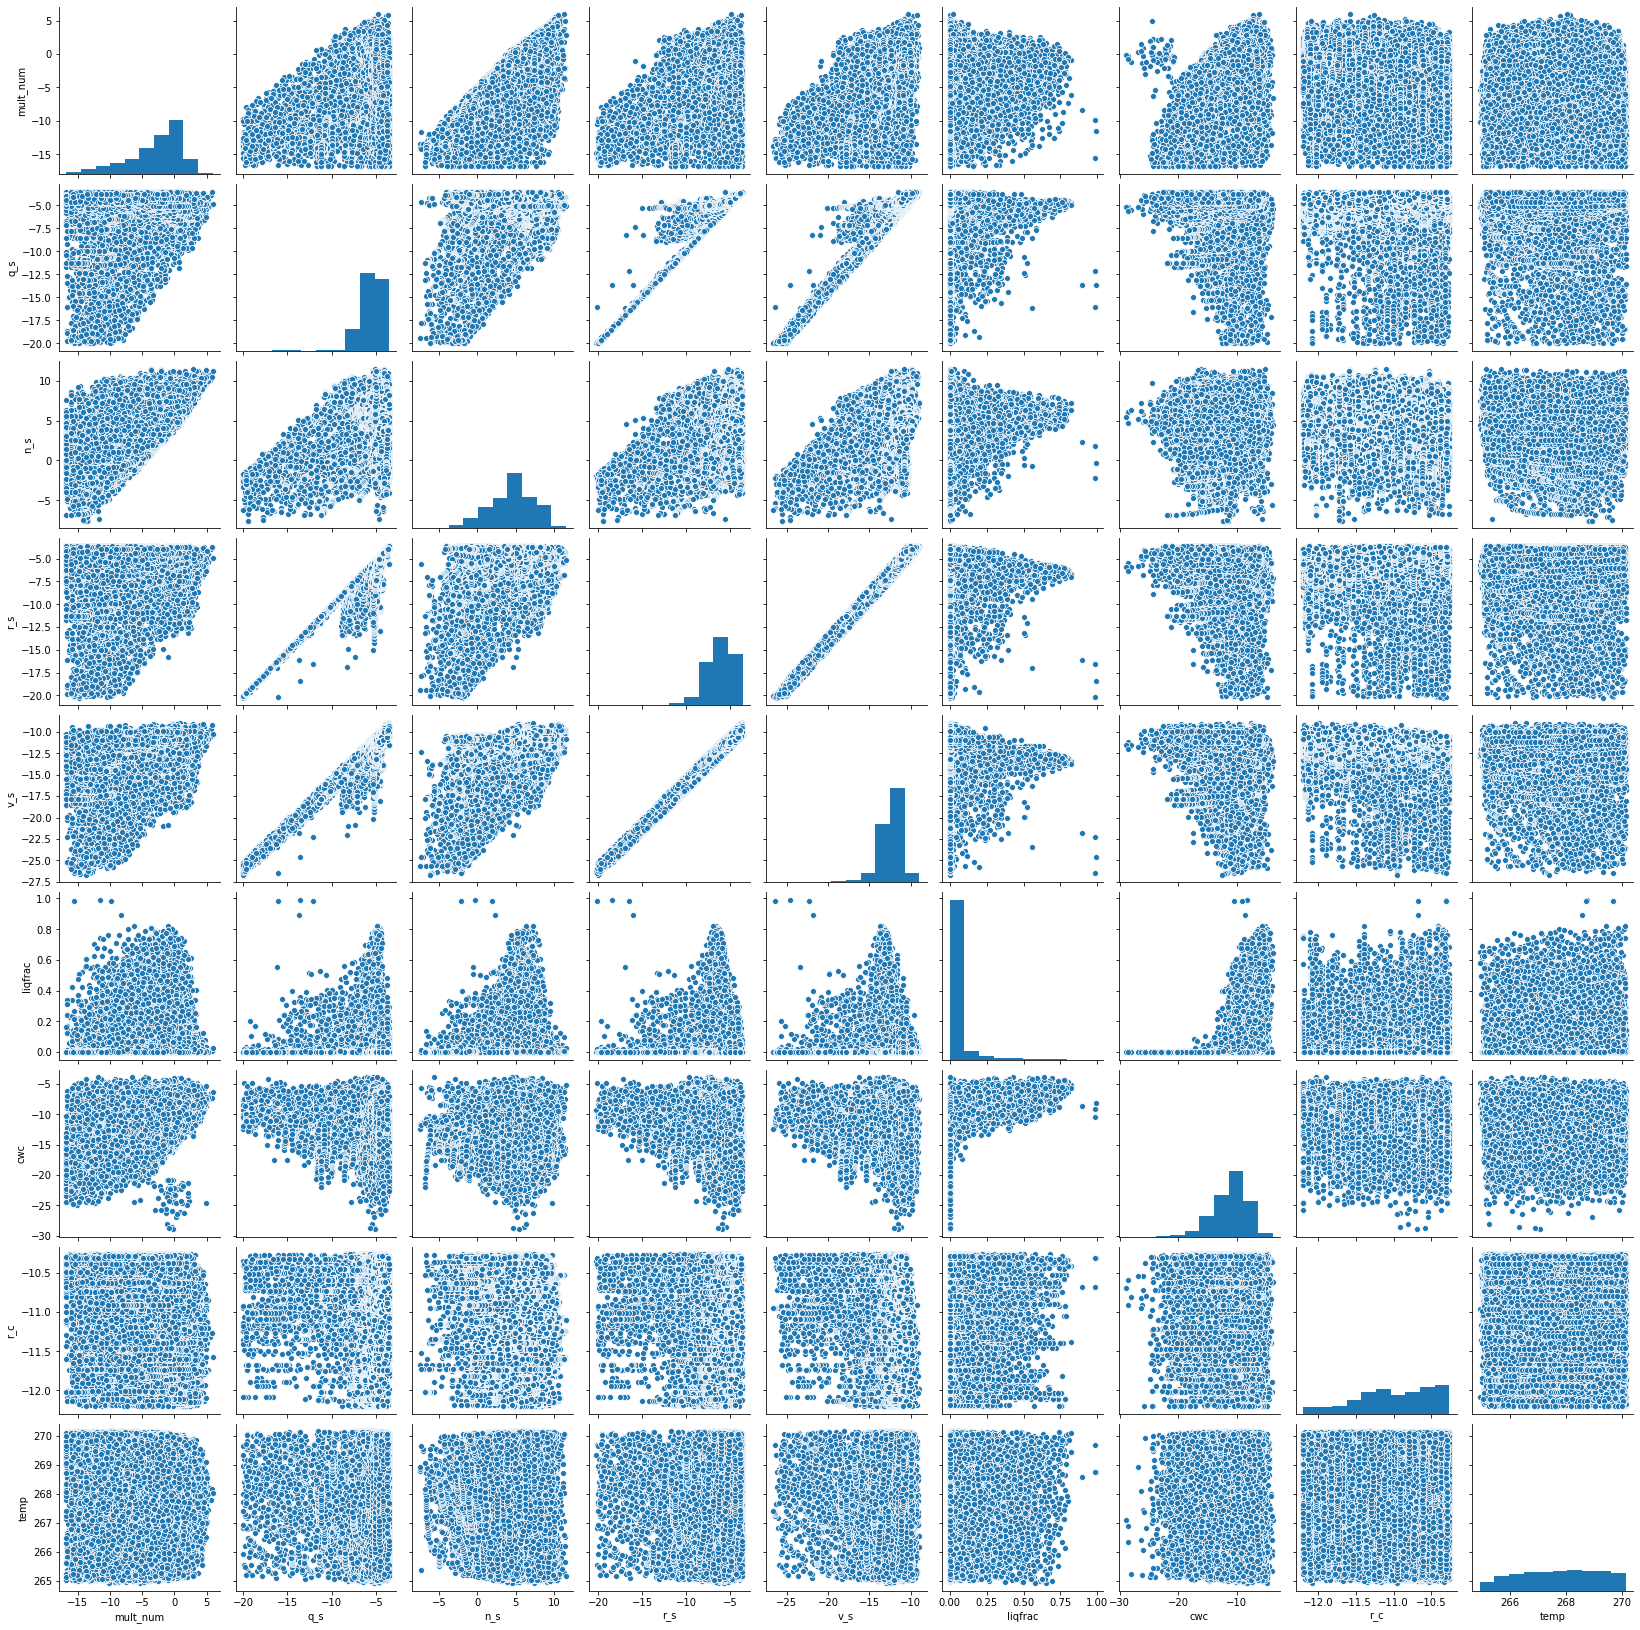

In [18]:
sns.pairplot(dataset_train[["mult_num","q_s","n_s","r_s","v_s","liqfrac","cwc","r_c","temp"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['liqfrac','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['liqfrac','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['liqfrac','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("mult_num")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean       std         min         25%         50%  \
q_s   68062.0   -5.731374  1.679205  -19.996828   -6.376583   -5.459320   
n_s   68062.0    4.467721  2.878241   -7.574514    2.534907    4.717472   
r_s   68062.0   -6.378319  1.885624  -20.246225   -7.252491   -6.169300   
v_s   68062.0  -12.504087  1.700655  -26.684860  -13.051719  -12.231637   
cwc   68062.0  -11.127609  2.877443  -28.879293  -12.867722  -10.780558   
r_c   68062.0  -10.996731  0.490690  -12.203955  -11.334051  -10.958007   
temp  68062.0  267.734985  1.399022  264.920013  266.589996  267.790009   

             75%         max  
q_s    -4.729269   -3.507425  
n_s     6.582700   11.563048  
r_s    -5.063708   -3.592370  
v_s   -11.511327   -8.961373  
cwc    -9.079312   -3.897134  
r_c   -10.565485  -10.260165  
temp  268.929993  270.149994

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("mult_num")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_s      68062.0   -5.731374  1.679205  -19.996828   -6.376583   -5.459320   
n_s      68062.0    4.467721  2.878241   -7.574514    2.534907    4.717472   
r_s      68062.0   -6.378319  1.885624  -20.246225   -7.252491   -6.169300   
v_s      68062.0  -12.504087  1.700655  -26.684860  -13.051719  -12.231637   
liqfrac  68062.0    0.031301  0.083810    0.000000    0.000013    0.001005   
cwc      68062.0  -11.127609  2.877443  -28.879293  -12.867722  -10.780558   
r_c      68062.0  -10.996731  0.490690  -12.203955  -11.334051  -10.958007   
temp     68062.0  267.734985  1.399022  264.920013  266.589996  267.790009   

                75%         max  
q_s       -4.729269   -3.507425  
n_s        6.582700   11.563048  
r_s       -5.063708   -3.592370  
v_s      -11.511327   -8.961373  
liqfrac    0.013023    0.989692  
cwc       -9.079312   -3.897134  
r_c      -10.565485  -10.260165  
temp     268.929993  270.149994

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("mult_num")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s      68062.0   -5.731374  1.679205  -19.996828   -6.376583   -5.459320   
n_s      68062.0    4.467721  2.878241   -7.574514    2.534907    4.717472   
r_s      68062.0   -6.378319  1.885624  -20.246225   -7.252491   -6.169300   
v_s      68062.0  -12.504087  1.700655  -26.684860  -13.051719  -12.231637   
liqfrac  68062.0    0.031301  0.083810    0.000000    0.000013    0.001005   
cwc      68062.0  -11.127609  2.877443  -28.879293  -12.867722  -10.780558   
r_c      68062.0  -10.996731  0.490690  -12.203955  -11.334051  -10.958007   
temp     68062.0  267.734985  1.399022  264.920013  266.589996  267.790009   
rho      68062.0    1.045333  0.050153    0.841000    1.011000    1.045000   

                75%         max  
q_s       -4.729269   -3.507425  
n_s        6.582700   11.563048  
r_s       -5.063708   -3.592370  
v_s      -11.511327   -8.961373  
liqfrac    0.013023    0.989692  
cwc       -9.079312   -3.897134  
r_c      -10.565485  -10.260165  
temp     268.929993  270.149994  
rho        1.082000    1.220000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['mult_num']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

mult_num
count  68062.000000
mean      -2.993480
std        4.185363
min      -16.801191
25%       -5.184360
50%       -1.763680
75%        0.066738
max        5.923868

In [32]:
train_dataset1.describe()

q_s           n_s           r_s           v_s           cwc  \
count  68062.000000  68062.000000  68062.000000  68062.000000  68062.000000   
mean      -5.731374      4.467721     -6.378319    -12.504087    -11.127609   
std        1.679205      2.878241      1.885624      1.700655      2.877443   
min      -19.996828     -7.574514    -20.246225    -26.684860    -28.879293   
25%       -6.376583      2.534907     -7.252491    -13.051719    -12.867722   
50%       -5.459320      4.717472     -6.169300    -12.231637    -10.780558   
75%       -4.729269      6.582700     -5.063708    -11.511327     -9.079312   
max       -3.507425     11.563048     -3.592370     -8.961373     -3.897134   

                r_c          temp  
count  68062.000000  68062.000000  
mean     -10.996731    267.734985  
std        0.490690      1.399022  
min      -12.203955    264.920013  
25%      -11.334051    266.589996  
50%      -10.958007    267.790009  
75%      -10.565485    268.929993  
max      -10.260165    270.149994

In [33]:
train_dataset2.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  68062.000000  68062.000000  68062.000000  68062.000000  68062.000000   
mean      -5.731374      4.467721     -6.378319    -12.504087      0.031301   
std        1.679205      2.878241      1.885624      1.700655      0.083810   
min      -19.996828     -7.574514    -20.246225    -26.684860      0.000000   
25%       -6.376583      2.534907     -7.252491    -13.051719      0.000013   
50%       -5.459320      4.717472     -6.169300    -12.231637      0.001005   
75%       -4.729269      6.582700     -5.063708    -11.511327      0.013023   
max       -3.507425     11.563048     -3.592370     -8.961373      0.989692   

                cwc           r_c          temp  
count  68062.000000  68062.000000  68062.000000  
mean     -11.127609    -10.996731    267.734985  
std        2.877443      0.490690      1.399022  
min      -28.879293    -12.203955    264.920013  
25%      -12.867722    -11.334051    266.589996  
50%      -10.780558    -10.958007    267.790009  
75%       -9.079312    -10.565485    268.929993  
max       -3.897134    -10.260165    270.149994

In [34]:
train_dataset3.describe()

q_s           n_s           r_s           v_s       liqfrac  \
count  68062.000000  68062.000000  68062.000000  68062.000000  68062.000000   
mean      -5.731374      4.467721     -6.378319    -12.504087      0.031301   
std        1.679205      2.878241      1.885624      1.700655      0.083810   
min      -19.996828     -7.574514    -20.246225    -26.684860      0.000000   
25%       -6.376583      2.534907     -7.252491    -13.051719      0.000013   
50%       -5.459320      4.717472     -6.169300    -12.231637      0.001005   
75%       -4.729269      6.582700     -5.063708    -11.511327      0.013023   
max       -3.507425     11.563048     -3.592370     -8.961373      0.989692   

                cwc           r_c          temp           rho  
count  68062.000000  68062.000000  68062.000000  68062.000000  
mean     -11.127609    -10.996731    267.734985      1.045333  
std        2.877443      0.490690      1.399022      0.050153  
min      -28.879293    -12.203955    264.920013      0.841000  
25%      -12.867722    -11.334051    266.589996      1.011000  
50%      -10.780558    -10.958007    267.790009      1.045000  
75%       -9.079312    -10.565485    268.929993      1.082000  
max       -3.897134    -10.260165    270.149994      1.220000

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s   68062.0  2.074506e-07  1.0 -8.495362 -0.384235  0.162014  0.596773   
n_s   68062.0  1.159939e-07  1.0 -4.183888 -0.671527  0.086772  0.734816   
r_s   68062.0  2.284178e-07  1.0 -7.354545 -0.463598  0.110849  0.697175   
v_s   68062.0  1.771156e-07  1.0 -8.338416 -0.322012  0.160203  0.583752   
cwc   68062.0  1.414324e-07  1.0 -6.169256 -0.604743  0.120611  0.711846   
r_c   68062.0 -1.203924e-06  1.0 -2.460258 -0.687441  0.078917  0.878856   
temp  68062.0  2.103087e-06  1.0 -2.012100 -0.818421  0.039330  0.854174   

           max  
q_s   1.324406  
n_s   2.465161  
r_s   1.477468  
v_s   2.083146  
cwc   2.512812  
r_c   1.501082  
temp  1.726212

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s      68062.0  2.074506e-07  1.0 -8.495362 -0.384235  0.162014  0.596773   
n_s      68062.0  1.159939e-07  1.0 -4.183888 -0.671527  0.086772  0.734816   
r_s      68062.0  2.284178e-07  1.0 -7.354545 -0.463598  0.110849  0.697175   
v_s      68062.0  1.771156e-07  1.0 -8.338416 -0.322012  0.160203  0.583752   
liqfrac  68062.0  1.740071e-08  1.0 -0.373476 -0.373323 -0.361484 -0.218085   
cwc      68062.0  1.414324e-07  1.0 -6.169256 -0.604743  0.120611  0.711846   
r_c      68062.0 -1.203924e-06  1.0 -2.460258 -0.687441  0.078917  0.878856   
temp     68062.0  2.103087e-06  1.0 -2.012100 -0.818421  0.039330  0.854174   

               max  
q_s       1.324406  
n_s       2.465161  
r_s       1.477468  
v_s       2.083146  
liqfrac  11.435297  
cwc       2.512812  
r_c       1.501082  
temp      1.726212

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s      68062.0  2.074506e-07  1.0 -8.495362 -0.384235  0.162014  0.596773   
n_s      68062.0  1.159939e-07  1.0 -4.183888 -0.671527  0.086772  0.734816   
r_s      68062.0  2.284178e-07  1.0 -7.354545 -0.463598  0.110849  0.697175   
v_s      68062.0  1.771156e-07  1.0 -8.338416 -0.322012  0.160203  0.583752   
liqfrac  68062.0  1.740071e-08  1.0 -0.373476 -0.373323 -0.361484 -0.218085   
cwc      68062.0  1.414324e-07  1.0 -6.169256 -0.604743  0.120611  0.711846   
r_c      68062.0 -1.203924e-06  1.0 -2.460258 -0.687441  0.078917  0.878856   
temp     68062.0  2.103087e-06  1.0 -2.012100 -0.818421  0.039330  0.854174   
rho      68062.0  4.136043e-06  1.0 -4.074185 -0.684570 -0.006648  0.731093   

               max  
q_s       1.324406  
n_s       2.465161  
r_s       1.477468  
v_s       2.083146  
liqfrac  11.435297  
cwc       2.512812  
r_c       1.501082  
temp      1.726212  
rho       3.482663

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count     mean       std        min      25%      50%       75%  \
mult_num  68062.0 -2.99348  4.185363 -16.801191 -5.18436 -1.76368  0.066738   

               max  
mult_num  5.923868

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(7,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8180593 ],
       [-0.8222257 ],
       [-0.82438296],
       [-0.8270582 ],
       [-0.82793593],
       [-0.8286496 ],
       [-0.8292976 ],
       [-0.82980216],
       [-0.8306373 ],
       [-0.8313104 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.4361,  mae:0.4822,  mse:0.4361,  val_loss:0.3326,  val_mae:0.4484,  val_mse:0.3326,  
....................................................................................................
Epoch: 100, loss:0.0758,  mae:0.1599,  mse:0.0758,  val_loss:0.0734,  val_mae:0.1537,  val_mse:0.0734,  
....................................................................................................
Epoch: 200, loss:0.0659,  mae:0.1467,  mse:0.0659,  val_loss:0.0661,  val_mae:0.1481,  val_mse:0.0661,  
....................................................................................................

Text(0, 0.5, 'MAE')

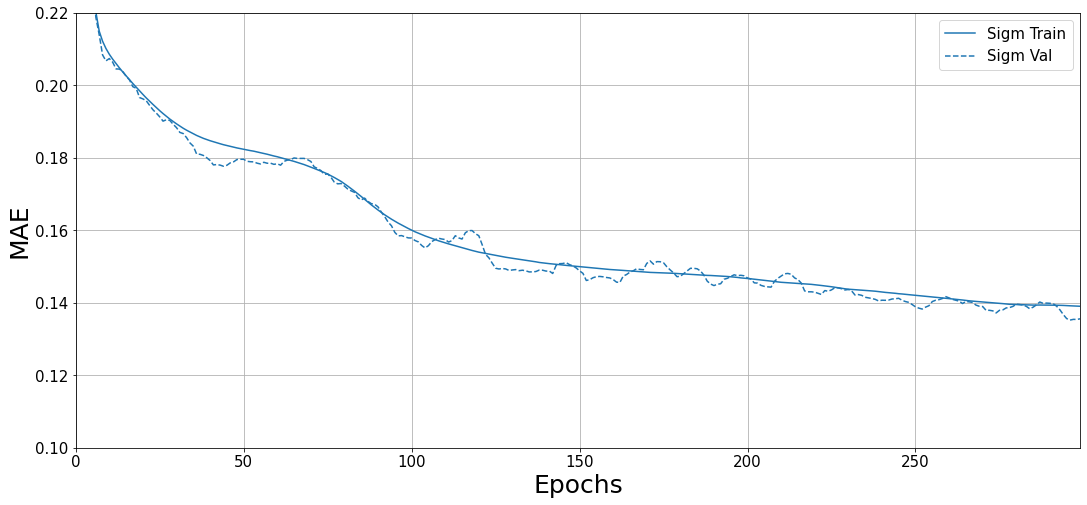

In [47]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

In [48]:
activ = "ReLU"
model2 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1802,  mae:0.2805,  mse:0.1802,  val_loss:0.1202,  val_mae:0.2196,  val_mse:0.1202,  
....................................................................................................
Epoch: 100, loss:0.0621,  mae:0.1400,  mse:0.0621,  val_loss:0.0623,  val_mae:0.1360,  val_mse:0.0623,  
.........................

Text(0, 0.5, 'MAE')

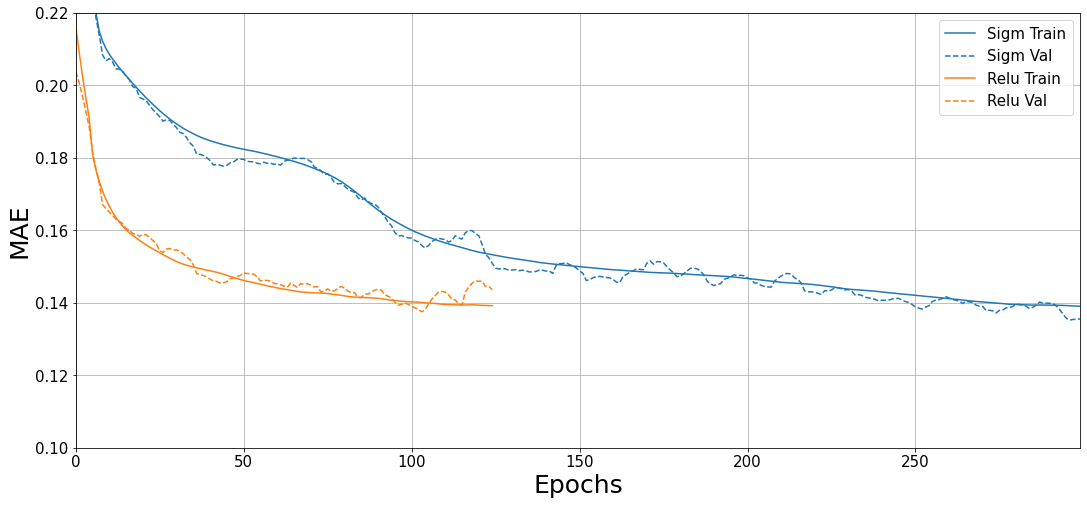

In [49]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

In [50]:
activ = "ReLU"
model3 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1694,  mae:0.2628,  mse:0.1694,  val_loss:0.1123,  val_mae:0.2022,  val_mse:0.1123,  
....................................................................................................
Epoch: 100, loss:0.0550,  mae:0.1286,  mse:0.0550,  val_loss:0.0550,  val_mae:0.1250,  val_mse:0.0550,  
.....................

Text(0, 0.5, 'MAE')

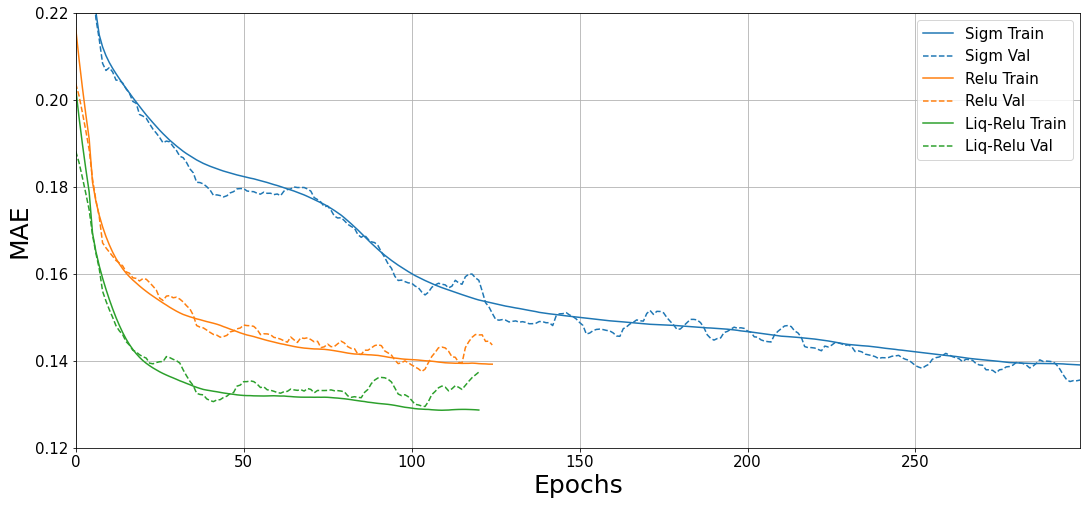

In [51]:
histories['liq-ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.22])
plt.ylabel('MAE')

In [52]:
model4 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2031,  mae:0.2948,  mse:0.2031,  val_loss:0.1162,  val_mae:0.2190,  val_mse:0.1162,  
........................................................................................

Text(0, 0.5, 'MAE')

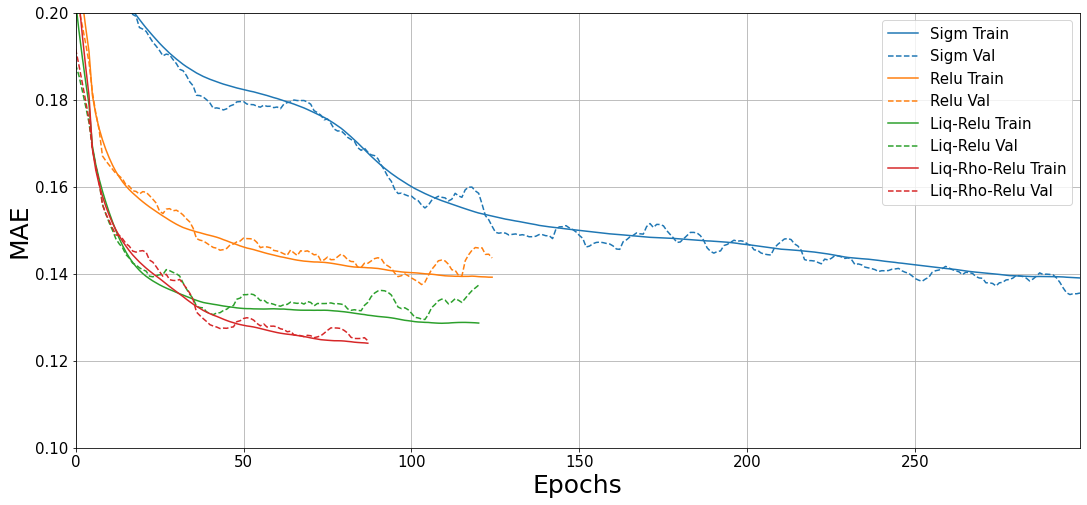

In [53]:
histories['liq-rho-ReLU'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.10, 0.20])
plt.ylabel('MAE')

In [54]:
activ = "ReLU_Adam"
model5 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history5 = model5.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1787,  mae:0.2797,  mse:0.1787,  val_loss:0.1219,  val_mae:0.2304,  val_mse:0.1219,  
....................................................................................................
Epoch: 100, loss:0.0523,  mae:0.1338,  mse:0.0523,  val_loss:0.0579,  val_mae:0.1400,  val_mse:0.0579,  
.........................

Text(0, 0.5, 'MAE')

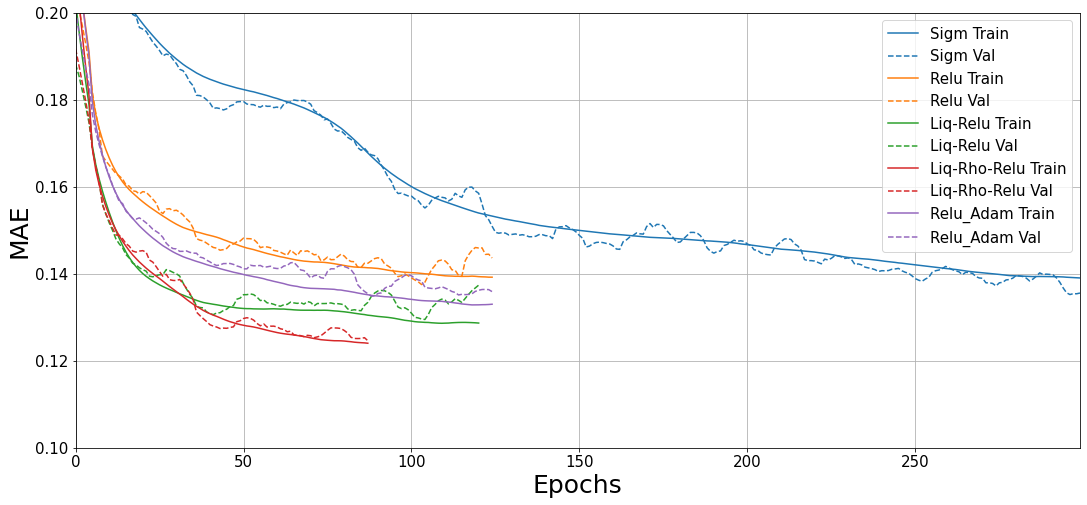

In [55]:
histories['ReLU_Adam'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.20])
plt.ylabel('MAE')

In [56]:
model6 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history6 = model6.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1704,  mae:0.2673,  mse:0.1704,  val_loss:0.1121,  val_mae:0.2179,  val_mse:0.1121,  
....................................................................................................
Epoch: 100, loss:0.0485,  mae:0.1250,  mse:0.0485,  val_loss:0.0554,  val_mae:0.1282,  val_mse:0.0554,  
..........................................

Text(0, 0.5, 'MAE')

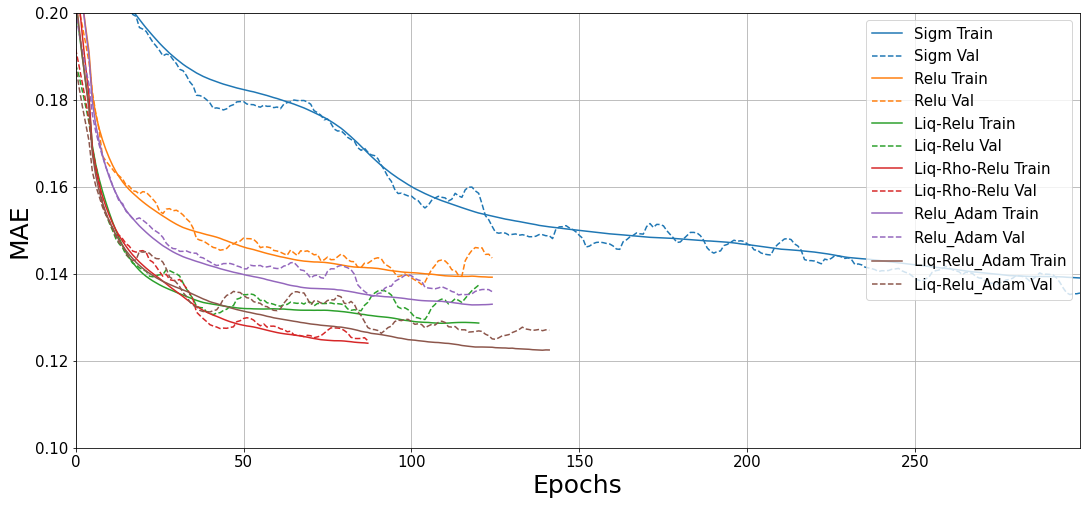

In [57]:
histories['liq-ReLU_Adam'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.10, 0.20])
plt.ylabel('MAE')

In [58]:
model7 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history7 = model7.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2084,  mae:0.3012,  mse:0.2084,  val_loss:0.1212,  val_mae:0.2277,  val_mse:0.1212,  
....................................................................................................
Epoch: 100, loss:0.0464,  mae:0.1209,  mse:0.0464,  val_loss:0.0517,  val_mae:0.1261,  val_mse:0.0517,  
...........

Text(0, 0.5, 'MAE')

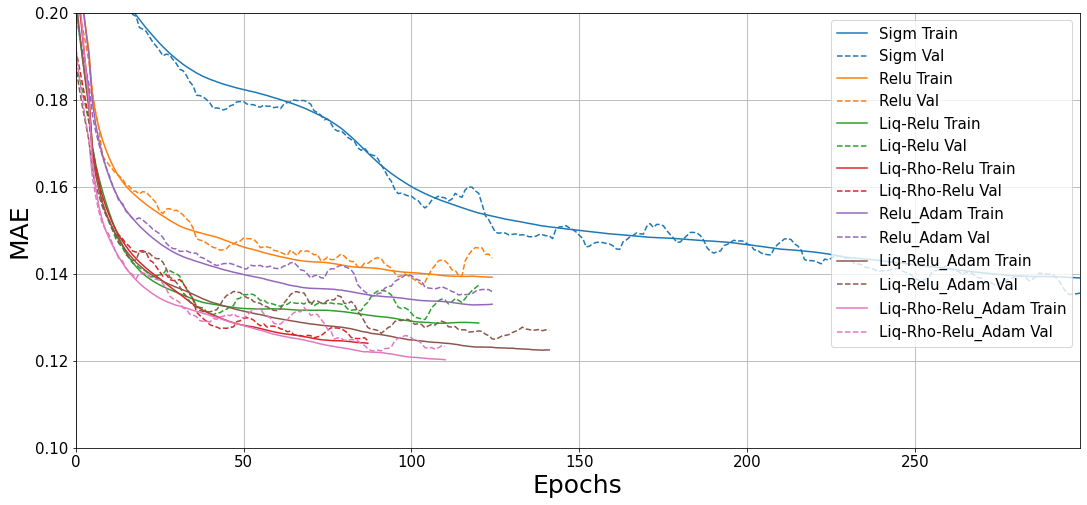

In [59]:
histories['liq-rho-ReLU_Adam'] = early_history7

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.10, 0.20])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

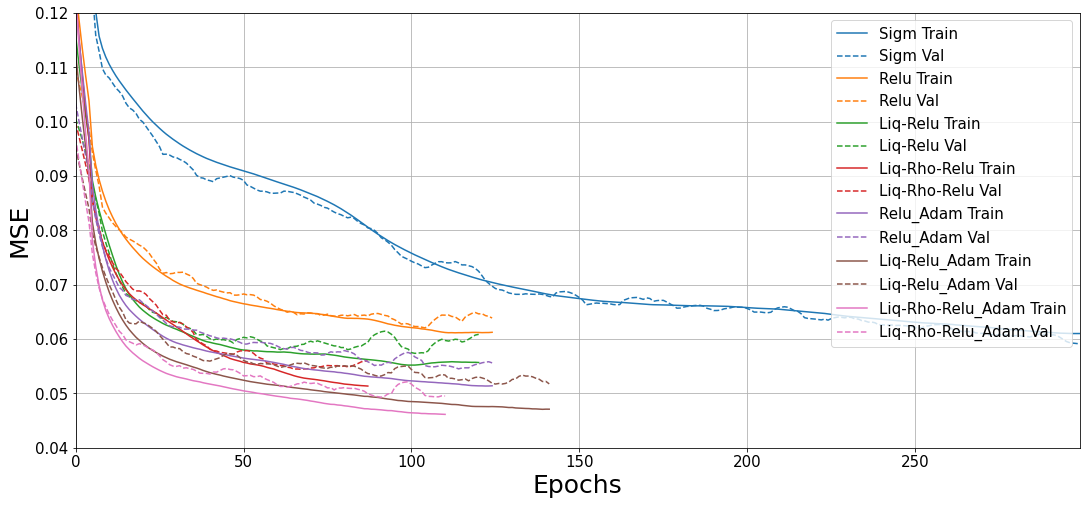

In [62]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.04, 0.12])
plt.ylabel('MSE')

In [63]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

14673/14673 - 0s - loss: 0.0616 - mae: 0.1408 - mse: 0.0616
Testing set for model 1, Mean Abs Error:    0.14078


In [64]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

14673/14673 - 0s - loss: 0.0621 - mae: 0.1374 - mse: 0.0621
Testing set for model 2, Mean Abs Error:              0.13736


In [65]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

14673/14673 - 0s - loss: 0.0546 - mae: 0.1252 - mse: 0.0546
Testing set for model 3, Mean Abs Error:              0.12517


In [66]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

14673/14673 - 0s - loss: 0.0513 - mae: 0.1235 - mse: 0.0513
Testing set for model 4, Mean Abs Error:              0.12348


In [67]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

14673/14673 - 0s - loss: 0.0531 - mae: 0.1336 - mse: 0.0531
Testing set for model 5, Mean Abs Error:              0.13356


In [68]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

14673/14673 - 0s - loss: 0.0488 - mae: 0.1238 - mse: 0.0488
Testing set for model 6, Mean Abs Error:              0.12377


In [69]:
loss7, mae7, mse7 = model7.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

14673/14673 - 0s - loss: 0.0467 - mae: 0.1205 - mse: 0.0467
Testing set for model 6, Mean Abs Error:              0.12377


In [70]:
mae = [ mae1, mae2, mae3, mae4, mae5, mae6, mae7 ]
mae

[0.14078051,
 0.13736379,
 0.12517218,
 0.12348164,
 0.13355578,
 0.12376971,
 0.120466866]

In [71]:
mse = [ mse1, mse2, mse3, mse4, mse5, mse6, mse7 ]
mse

[0.061637226,
 0.062051196,
 0.054627404,
 0.05129877,
 0.053116504,
 0.048794694,
 0.046733357]

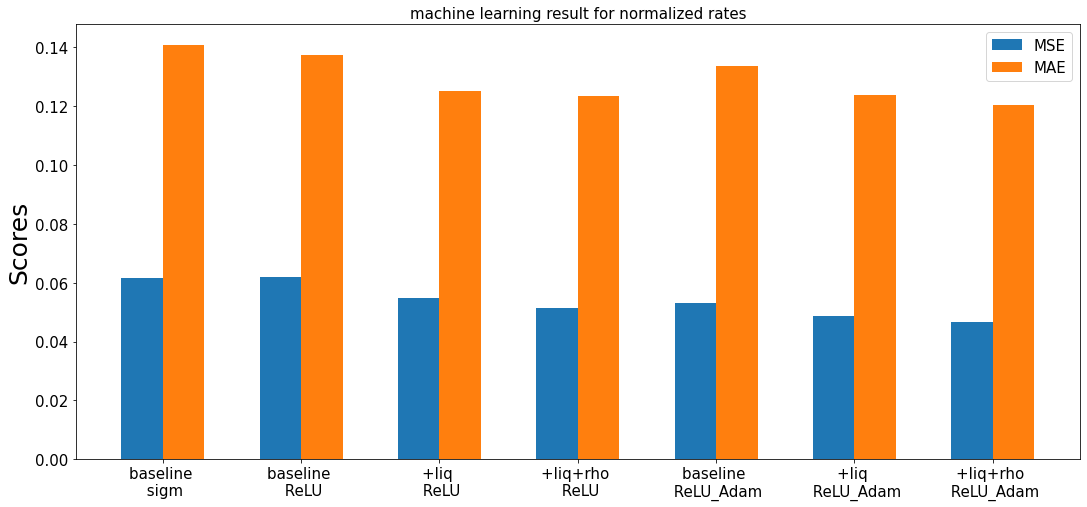

In [72]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['baseline \n sigm',
 'baseline \n ReLU',
 '+liq \n ReLU',
 '+liq+rho \n ReLU',
 'baseline \n ReLU_Adam',
 '+liq \n ReLU_Adam',
 '+liq+rho \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [73]:
test_true  = np.exp(test_labels.pop('mult_num'))

In [74]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [75]:
labels = [ "mult_num" ]

p1 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=labels)

In [76]:
p1.describe()

mult_num
count  14673.000000
mean       0.031470
std        0.960820
min       -3.977352
25%       -0.531876
50%        0.311957
75%        0.737752
max        1.895096

In [77]:
train_labels_stats

count     mean       std        min      25%      50%       75%  \
mult_num  68062.0 -2.99348  4.185363 -16.801191 -5.18436 -1.76368  0.066738   

               max  
mult_num  5.923868

In [78]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [79]:
test_predict1.describe()

mult_num
count  1.467300e+04
mean   1.720045e+00
std    5.844970e+00
min    2.953891e-09
25%    5.409635e-03
50%    1.849213e-01
75%    1.098870e+00
max    1.395166e+02

In [80]:
np.exp(test_dataset1.head())

q_s          n_s       r_s           v_s       cwc       r_c  temp
9    0.000369  3995.800781  0.000085  5.539699e-07  0.000061  0.000005   inf
11   0.000383  3966.698242  0.000096  6.239503e-07  0.000047  0.000005   inf
34   0.000467  3686.299805  0.000161  1.022100e-06  0.000263  0.000005   inf
37   0.000551  3664.298828  0.000242  1.545201e-06  0.000178  0.000005   inf
286  0.000356  5899.398926  0.000107  5.086200e-07  0.000515  0.000014   inf

In [81]:
test_predict1.head()

mult_num
0  3.661296
1  3.749200
2  9.715238
3  8.400265
4  8.660938

In [82]:
test_dataset2.head()

q_s       n_s       r_s        v_s   liqfrac       cwc        r_c  \
9   -7.904172  8.292999 -9.378451 -14.406156  0.000000 -9.702999 -12.155304   
11  -7.867815  8.285689 -9.255986 -14.287195  0.000000 -9.963238 -12.155304   
34  -7.668346  8.212379 -8.735474 -13.793652  0.000266 -8.243357 -12.155304   
37  -7.504611  8.206392 -8.327689 -13.380357  0.000078 -8.633727 -12.155304   
286 -7.940299  8.682606 -9.142028 -14.491565  0.000188 -7.571343 -11.148866   

           temp  
9    266.480011  
11   266.619995  
34   268.290009  
37   268.519989  
286  266.049988

In [83]:
test_predict1  = test_predict1['mult_num']

In [84]:

p2 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2 = test_predict2['mult_num']

In [85]:

p3 = pd.DataFrame(data=model4.predict(normed_test_data3), columns=labels)

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3 = test_predict3['mult_num']


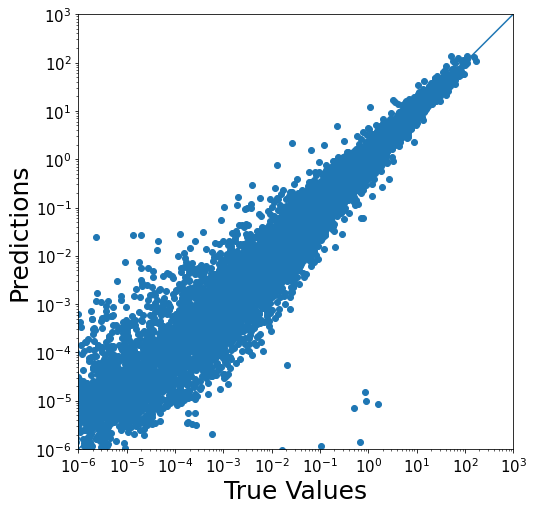

In [86]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-6, 1e3

a = plt.axes(aspect='equal')
plt.scatter(test_true, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

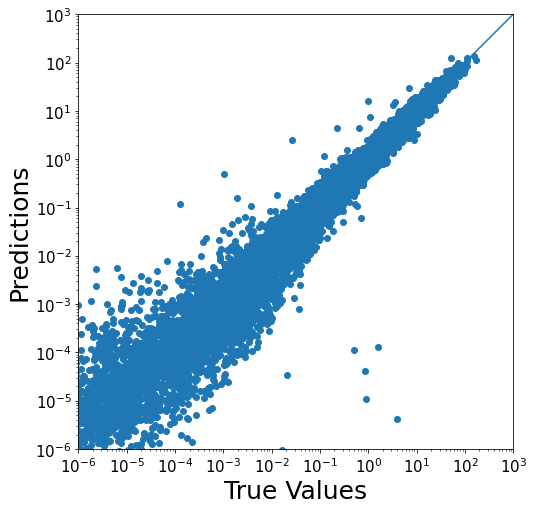

In [87]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

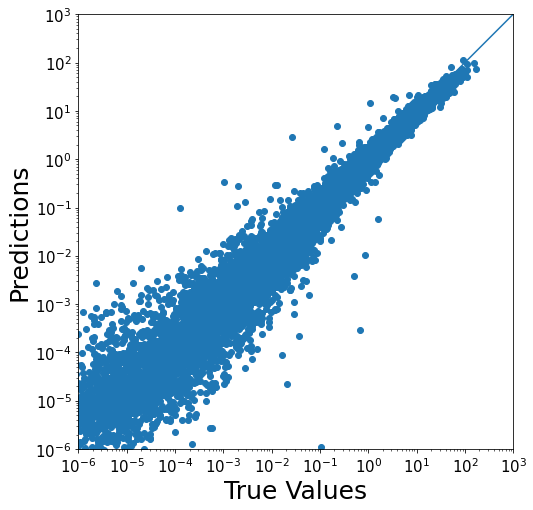

In [88]:
a = plt.axes(aspect='equal')
plt.scatter(test_true, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [89]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [90]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [91]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, cwc, rc, T'
labels   = 'mult_rimedsnow_cloud_num'
filename = 'saved_model_v2/mult_rimedsnow_cloud_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True, True, True, False], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/mult_rimedsnow_cloud_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/mult_rimedsnow_cloud_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats1,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/mult_rimedsnow_cloud_model1_07.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, cwc, rc, T
  Labels:     mult_rimedsnow_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/mult_rimedsnow_cloud_model2_07.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, cwc, rc, T
  Labels:     mult_rimedsnow_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1

In [92]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T'
filename = 'saved_model_v2/mult_rimedsnow_cloud_model3_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, True, True, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/mult_rimedsnow_cloud_model6_'+version+'.nc'
save2netcdf(model6,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/mult_rimedsnow_cloud_model3_07.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T
  Labels:     mult_rimedsnow_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/mult_rimedsnow_cloud_model6_07.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T
  Labels:     mult_rimedsnow_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'

In [93]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T, rho'
filename = 'saved_model_v2/mult_rimedsnow_cloud_model4_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, True, True, False, False], dtype=bool)
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/mult_rimedsnow_cloud_model7_'+version+'.nc'
save2netcdf(model7,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/mult_rimedsnow_cloud_model4_07.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T, rho
  Labels:     mult_rimedsnow_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/mult_rimedsnow_cloud_model7_07.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T, rho
  Labels:     mult_rimedsnow_cloud_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.c